# **AI-powered Football Player Tracking and Movement Analysis**

This project focuses on applying **deep learning** and **computer vision** techniques to automatically detect and track football players in match footage.  
By leveraging segmentation and movement visualization, the system highlights player positions, draws trajectories, and provides insights into their movements across the field.

---
# ✨ **Key Features**
- ⚽ Automatic player detection from raw match images.  
- 🎯 Segmentation-based identification of players using a custom-trained deep learning model.  
- 📊 Visualization of player movements with arrows and bounding shapes.  
- 🔍 Potential extension for performance analytics (e.g., distance covered, speed estimation, heatmaps).  
---
# 🎯 **Benefits**
- Provides coaches and analysts with **automated movement insights**.  
- Helps in tactical evaluation by identifying **player positioning and transitions**.  
- Can serve as a foundation for building **AI-powered sports analytics platforms**.

# **Setup & Installs**

In [1]:
!pip install -q segmentation-models-pytorch==0.3.3 \
    timm==0.9.2 \
    pretrainedmodels==0.7.4 \
    efficientnet-pytorch==0.7.1 \
    albumentations==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#  **Imports**


In [2]:
import os
import random
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

#   **Configuration**


In [3]:

DATA_DIR = Path('/kaggle/input/football-player-segmentation')   
OUTPUT_DIR = Path('/kaggle/working') / 'segmentation_output'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Training hyperparams
CFG = {
    'seed': 42,
    'img_size': 512,          
    'batch_size': 8,
    'epochs': 15,
    'learning_rate': 1e-4,
    'encoder': 'resnet34',    
    'encoder_weights': 'imagenet',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(CFG['seed'])
print('Device:', CFG['device'])

Device: cuda


In [4]:
import cv2
from pathlib import Path
from pycocotools.coco import COCO

DATA_DIR = "/kaggle/input/football-player-segmentation"
IMG_DIR = f"{DATA_DIR}/images"
ANN_FILE = f"{DATA_DIR}/annotations/instances_default.json"
MASK_DIR = "/kaggle/working/masks"  # masks output

os.makedirs(MASK_DIR, exist_ok=True)

coco = COCO(ANN_FILE)

print(" Generating masks from COCO JSON...")

for img_id in coco.getImgIds():
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info["file_name"]
    h, w = img_info["height"], img_info["width"]

    mask = np.zeros((h, w), dtype=np.uint8)

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        cat_id = ann["category_id"]  
        mask = np.maximum(mask, coco.annToMask(ann) * cat_id)

    mask_path = os.path.join(MASK_DIR, Path(file_name).stem + "_mask.png")
    cv2.imwrite(mask_path, mask)

print(" Masks generated successfully!")

IMG_EXTS = ['.png', '.jpg', '.jpeg']

image_paths = []
mask_paths = []

for root, dirs, files in os.walk(IMG_DIR):
    for f in files:
        if Path(f).suffix.lower() in IMG_EXTS:
            image_paths.append(Path(root) / f)

for root, dirs, files in os.walk(MASK_DIR):
    for f in files:
        if Path(f).suffix.lower() in IMG_EXTS:
            mask_paths.append(Path(root) / f)

images_by_stem = {p.stem: p for p in image_paths}
masks_by_stem = {p.stem.replace("_mask",""): p for p in mask_paths}

pairs = []
for stem, imgp in images_by_stem.items():
    if stem in masks_by_stem:
        pairs.append((imgp, masks_by_stem[stem]))

print(f" Found {len(image_paths)} images, 🖼 {len(mask_paths)} masks,  Paired: {len(pairs)}")

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
 Generating masks from COCO JSON...
 Masks generated successfully!
 Found 512 images, 🖼 512 masks,  Paired: 512


#  **EDA & visualization**


Total valid pairs for EDA: 512


EDA samples:   0%|          | 0/200 [00:00<?, ?it/s]

Image sizes (w x h): 1920 x 1080 to 1920 x 1080
Mask coverage (fraction): mean= 0.017538283661265433 median= 0.01834080825617284


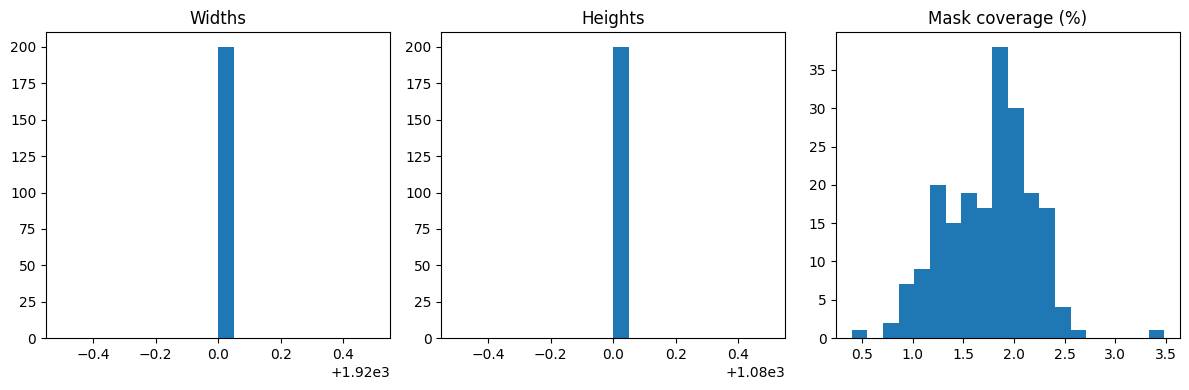

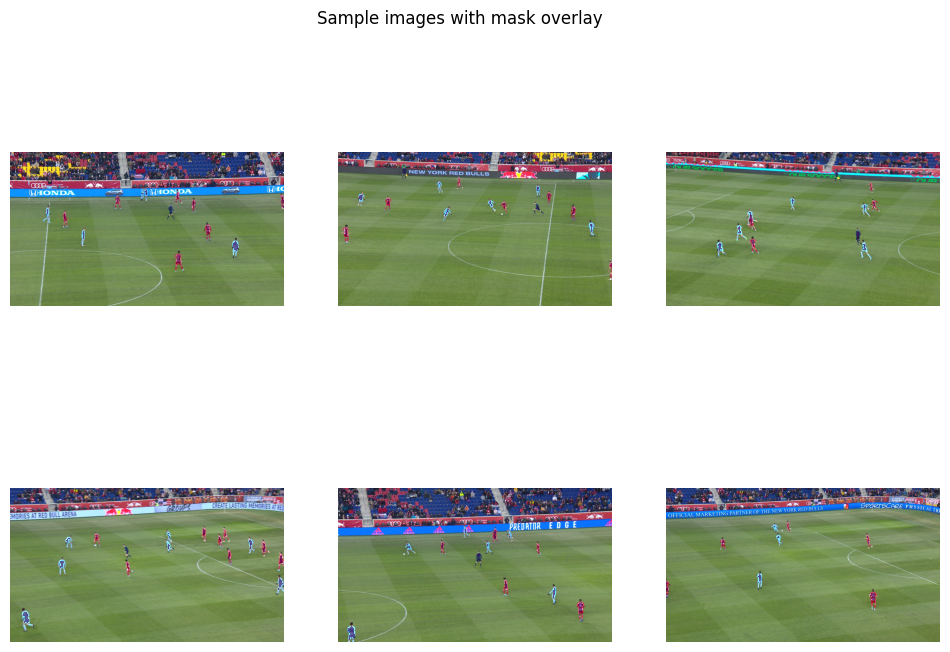

In [5]:
from PIL import Image

valid_exts = (".png", ".jpg", ".jpeg")
pairs_filtered = [(imgp, mskp) for imgp, mskp in pairs if str(mskp).lower().endswith(valid_exts)]

print(f"Total valid pairs for EDA: {len(pairs_filtered)}")

if len(pairs_filtered) == 0:
    print("No valid image-mask pairs for EDA. Please check dataset.")
else:
    heights, widths, mask_coverage = [], [], []

    sample_pairs = pairs_filtered[:200]  
    for imgp, mskp in tqdm(sample_pairs, desc="EDA samples"):
        img = Image.open(imgp).convert('RGB')
        m = Image.open(mskp).convert('L')
        w, h = img.size
        widths.append(w); heights.append(h)
        arr = np.array(m)
        coverage = float((arr > 0).mean())
        mask_coverage.append(coverage)

    print('Image sizes (w x h):', np.min(widths), 'x', np.min(heights),
          'to', np.max(widths), 'x', np.max(heights))
    print('Mask coverage (fraction): mean=', np.mean(mask_coverage), 
          'median=', np.median(mask_coverage))

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.hist(widths, bins=20); plt.title('Widths')
    plt.subplot(1,3,2)
    plt.hist(heights, bins=20); plt.title('Heights')
    plt.subplot(1,3,3)
    plt.hist([c*100 for c in mask_coverage], bins=20); plt.title('Mask coverage (%)')
    plt.tight_layout(); plt.show()

    n = min(6, len(pairs_filtered))
    plt.figure(figsize=(12,8))
    for i, (imgp, mskp) in enumerate(pairs_filtered[:n]):
        img = np.array(Image.open(imgp).convert('RGB'))
        m = np.array(Image.open(mskp).convert('L'))
        plt.subplot(2,3,i+1)
        plt.imshow(img)
        plt.imshow(np.ma.masked_where(m==0, m), alpha=0.6)
        plt.axis('off')
    plt.suptitle('Sample images with mask overlay')
    plt.show()

#  **Data augmentation and preprocessing**


In [6]:
train_transforms = A.Compose([
    A.Resize(CFG['img_size'], CFG['img_size']),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

valid_transforms = A.Compose([
    A.Resize(CFG['img_size'], CFG['img_size']),
    A.Normalize(),
    ToTensorV2()
])

#  **Dataset class and DataLoader**


In [7]:
class FootballSegDataset(Dataset):
    def __init__(self, pairs, transforms=None):
        self.pairs = pairs
        self.transforms = transforms

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('L'))
        mask = (mask > 127).astype('float32')

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']                
            mask = augmented['mask']              
            if isinstance(mask, np.ndarray):
                mask = torch.from_numpy(mask).float()
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
        else:
            img = T.ToTensor()(img)
            mask = torch.from_numpy(mask).unsqueeze(0).float()
        return img, mask

if len(pairs) > 0:
    ds = FootballSegDataset(pairs[:32], transforms=valid_transforms)
    dl = DataLoader(ds, batch_size=4, shuffle=False)
    imgs, msks = next(iter(dl))
    print('Batch shapes:', imgs.shape, msks.shape)

Batch shapes: torch.Size([4, 3, 512, 512]) torch.Size([4, 1, 512, 512])


#  **Model, loss, metrics**


In [8]:
model = smp.Unet(
    encoder_name=CFG['encoder'],
    encoder_weights=CFG['encoder_weights'],
    in_channels=3,
    classes=1,
)
model.to(CFG['device'])

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(preds.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        intersection = (preds * targets).sum(-1)
        denom = preds.sum(-1) + targets.sum(-1)
        dice = (2. * intersection + self.eps) / (denom + self.eps)
        return 1 - dice.mean()

bce = nn.BCEWithLogitsLoss()
dice = DiceLoss()

def loss_fn(preds, targets):
    return 0.5 * bce(preds, targets) + 0.5 * dice(preds, targets)

def iou_metric(preds, targets, thr=0.5, eps=1e-7):
    preds = torch.sigmoid(preds)
    preds = (preds > thr).float()
    preds = preds.view(preds.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    inter = (preds * targets).sum(-1)
    union = preds.sum(-1) + targets.sum(-1) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 303MB/s]


#  **Training and validation functions**


In [9]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

def train_one_epoch(epoch, model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Train E{epoch}")
    for i, (images, masks) in pbar:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        with autocast():
            preds = model(images)
            loss = loss_fn(preds, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        pbar.set_postfix(loss=f"{running_loss/(i+1):.4f}")
    return running_loss / len(dataloader)

def validate(epoch, model, dataloader, device, thr=0.5):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Val E{epoch}")
        for i, (images, masks) in pbar:
            images = images.to(device)
            masks = masks.to(device)
            preds = model(images)
            loss = loss_fn(preds, masks)
            running_loss += loss.item()
            running_iou += iou_metric(preds, masks, thr)
            pbar.set_postfix(loss=f"{running_loss/(i+1):.4f}", iou=f"{running_iou/(i+1):.4f}")
    return running_loss / len(dataloader), running_iou / len(dataloader)

/tmp/ipykernel_19/700038247.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **Define custom BCE + DiceLoss**


In [10]:

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)

        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice


class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss(smooth)

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return bce_loss + dice_loss

criterion = BCEDiceLoss(smooth=1.0).to(CFG['device'])

#  **Training and validation functions + loop**


In [11]:

def train_one_epoch(epoch, model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


def validate(epoch, model, loader, device):
    model.eval()
    running_loss = 0.0
    ious = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            intersection = (preds * masks).sum((1,2,3))
            union = preds.sum((1,2,3)) + masks.sum((1,2,3)) - intersection
            iou = ((intersection + 1e-6) / (union + 1e-6)).mean().item()
            ious.append(iou)

    epoch_loss = running_loss / len(loader.dataset)
    mean_iou = np.mean(ious)
    return epoch_loss, mean_iou

#  **Recreate loaders + train loop**


In [12]:
from torch.utils.data import DataLoader
device = CFG.get('device') if isinstance(CFG, dict) and 'device' in CFG else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

try:
    n_pairs = len(pairs)
except NameError:
    raise RuntimeError("Variable 'pairs' not found. Make sure you ran the cell that creates 'pairs'.")
if n_pairs == 0:
    raise RuntimeError("No pairs found. Make sure images and masks are paired correctly.")

seed = CFG.get('seed', 42) if isinstance(CFG, dict) else 42
random.seed(seed)
idxs = list(range(n_pairs))
random.shuffle(idxs)
split = int(0.8 * n_pairs)
train_idxs = idxs[:split]
valid_idxs = idxs[split:]

train_pairs = [pairs[i] for i in train_idxs]
valid_pairs = [pairs[i] for i in valid_idxs]

print(f"Total pairs: {n_pairs} | Train: {len(train_pairs)} | Val: {len(valid_pairs)}")


if 'train_transforms' not in globals():
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    train_transforms = A.Compose([A.Resize(CFG['img_size'], CFG['img_size']), A.Normalize(), ToTensorV2()])
if 'valid_transforms' not in globals():
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    valid_transforms = A.Compose([A.Resize(CFG['img_size'], CFG['img_size']), A.Normalize(), ToTensorV2()])

if 'FootballSegDataset' not in globals():
    raise RuntimeError("FootballSegDataset class not found. Please run the cell that defines the Dataset class.")

train_ds = FootballSegDataset(train_pairs, transforms=train_transforms)
valid_ds = FootballSegDataset(valid_pairs, transforms=valid_transforms)

num_workers = 2
try:
    train_loader = DataLoader(train_ds, batch_size=CFG['batch_size'], shuffle=True, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=CFG['batch_size'], shuffle=False, num_workers=num_workers, pin_memory=True)
except Exception as e:
    print("Warning: DataLoader with num_workers=2 failed, falling back to num_workers=0. Error:", e)
    train_loader = DataLoader(train_ds, batch_size=CFG['batch_size'], shuffle=True, num_workers=0, pin_memory=False)
    valid_loader = DataLoader(valid_ds, batch_size=CFG['batch_size'], shuffle=False, num_workers=0, pin_memory=False)

print("Train loader batches:", len(train_loader), " | Val loader batches:", len(valid_loader))


if 'model' not in globals():
    raise RuntimeError("Model 'model' not found. Please run the cell that creates the model (smp.Unet or other).")
model = model.to(device)

if 'criterion' not in globals():
    import torch.nn as nn
    class DiceLoss(nn.Module):
        def __init__(self, smooth=1.0):
            super(DiceLoss, self).__init__()
            self.smooth = smooth
        def forward(self, logits, targets):
            probs = torch.sigmoid(logits)
            probs = probs.contiguous().view(-1)
            targets = targets.contiguous().view(-1)
            intersection = (probs * targets).sum()
            dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
            return 1 - dice
    class BCEDiceLoss(nn.Module):
        def __init__(self, smooth=1.0):
            super(BCEDiceLoss, self).__init__()
            self.bce = nn.BCEWithLogitsLoss()
            self.dice = DiceLoss(smooth)
        def forward(self, logits, targets):
            return self.bce(logits, targets) + self.dice(logits, targets)
    criterion = BCEDiceLoss(smooth=1.0).to(device)

if 'optimizer' not in globals():
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.get('learning_rate', 1e-4))

if 'scheduler' not in globals():
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)


from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

def train_one_epoch(epoch, model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    for imgs, masks in tqdm(loader, desc=f"Train E{epoch}", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        total += batch_size
    epoch_loss = running_loss / (total if total>0 else 1)
    return epoch_loss

def validate(epoch, model, loader, device):
    model.eval()
    running_loss = 0.0
    ious = []
    total = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc=f"Val E{epoch}", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            batch_size = imgs.size(0)
            running_loss += loss.item() * batch_size
            total += batch_size

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            inter = (preds * masks).sum((1,2,3))
            union = preds.sum((1,2,3)) + masks.sum((1,2,3)) - inter
            iou_batch = ((inter + 1e-6) / (union + 1e-6)).cpu().numpy()
            ious.extend(iou_batch.tolist())

    epoch_loss = running_loss / (total if total>0 else 1)
    mean_iou = np.mean(ious) if len(ious)>0 else 0.0
    return epoch_loss, mean_iou


best_iou = 0.0
EPOCHS = CFG.get('epochs', 10)
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(epoch, model, train_loader, optimizer, device)
    val_loss, val_iou = validate(epoch, model, valid_loader, device)
    scheduler.step(val_iou)
    print(f"Epoch {epoch}/{EPOCHS} -> train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_iou: {val_iou:.4f}")
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), OUTPUT_DIR / 'best_model.pth')
        print(f"✅ Saved best model with IoU {best_iou:.4f}")

print("Training finished. Best IoU:", best_iou)

Using device: cuda
Total pairs: 512 | Train: 409 | Val: 103
Train loader batches: 52  | Val loader batches: 13


/tmp/ipykernel_19/1451970835.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Train E1:   0%|          | 0/52 [00:00<?, ?it/s]

/tmp/ipykernel_19/1451970835.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Val E1:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/15 -> train_loss: 1.6777 | val_loss: 1.4736 | val_iou: 0.0000
✅ Saved best model with IoU 0.0000


Train E2:   0%|          | 0/52 [00:00<?, ?it/s]

Val E2:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/15 -> train_loss: 1.3812 | val_loss: 1.3342 | val_iou: 0.0000
✅ Saved best model with IoU 0.0000


Train E3:   0%|          | 0/52 [00:00<?, ?it/s]

Val E3:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/15 -> train_loss: 1.3004 | val_loss: 1.2849 | val_iou: 0.0000
✅ Saved best model with IoU 0.0000


Train E4:   0%|          | 0/52 [00:00<?, ?it/s]

Val E4:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/15 -> train_loss: 1.2507 | val_loss: 1.2277 | val_iou: 0.0000
✅ Saved best model with IoU 0.0000


Train E5:   0%|          | 0/52 [00:00<?, ?it/s]

Val E5:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/15 -> train_loss: 1.2125 | val_loss: 1.1960 | val_iou: 0.0874
✅ Saved best model with IoU 0.0874


Train E6:   0%|          | 0/52 [00:00<?, ?it/s]

Val E6:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/15 -> train_loss: 1.1832 | val_loss: 1.1745 | val_iou: 0.8447
✅ Saved best model with IoU 0.8447


Train E7:   0%|          | 0/52 [00:00<?, ?it/s]

Val E7:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/15 -> train_loss: 1.1596 | val_loss: 1.1490 | val_iou: 0.9806
✅ Saved best model with IoU 0.9806


Train E8:   0%|          | 0/52 [00:00<?, ?it/s]

Val E8:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/15 -> train_loss: 1.1400 | val_loss: 1.1320 | val_iou: 1.0000
✅ Saved best model with IoU 1.0000


Train E9:   0%|          | 0/52 [00:00<?, ?it/s]

Val E9:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/15 -> train_loss: 1.1236 | val_loss: 1.1156 | val_iou: 1.0000


Train E10:   0%|          | 0/52 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x79ad63803ba0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ad63803ba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/

Val E10:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/15 -> train_loss: 1.1100 | val_loss: 1.1012 | val_iou: 1.0000


Train E11:   0%|          | 0/52 [00:00<?, ?it/s]

Val E11:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/15 -> train_loss: 1.0976 | val_loss: 1.0903 | val_iou: 1.0000


Train E12:   0%|          | 0/52 [00:00<?, ?it/s]

Val E12:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/15 -> train_loss: 1.0895 | val_loss: 1.0865 | val_iou: 1.0000


Train E13:   0%|          | 0/52 [00:00<?, ?it/s]

Val E13:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/15 -> train_loss: 1.0847 | val_loss: 1.0801 | val_iou: 1.0000


Train E14:   0%|          | 0/52 [00:00<?, ?it/s]

Val E14:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/15 -> train_loss: 1.0801 | val_loss: 1.0766 | val_iou: 1.0000


Train E15:   0%|          | 0/52 [00:00<?, ?it/s]

Val E15:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/15 -> train_loss: 1.0769 | val_loss: 1.0746 | val_iou: 1.0000
Training finished. Best IoU: 1.0


# **Inference helpers, TTA and visualization**


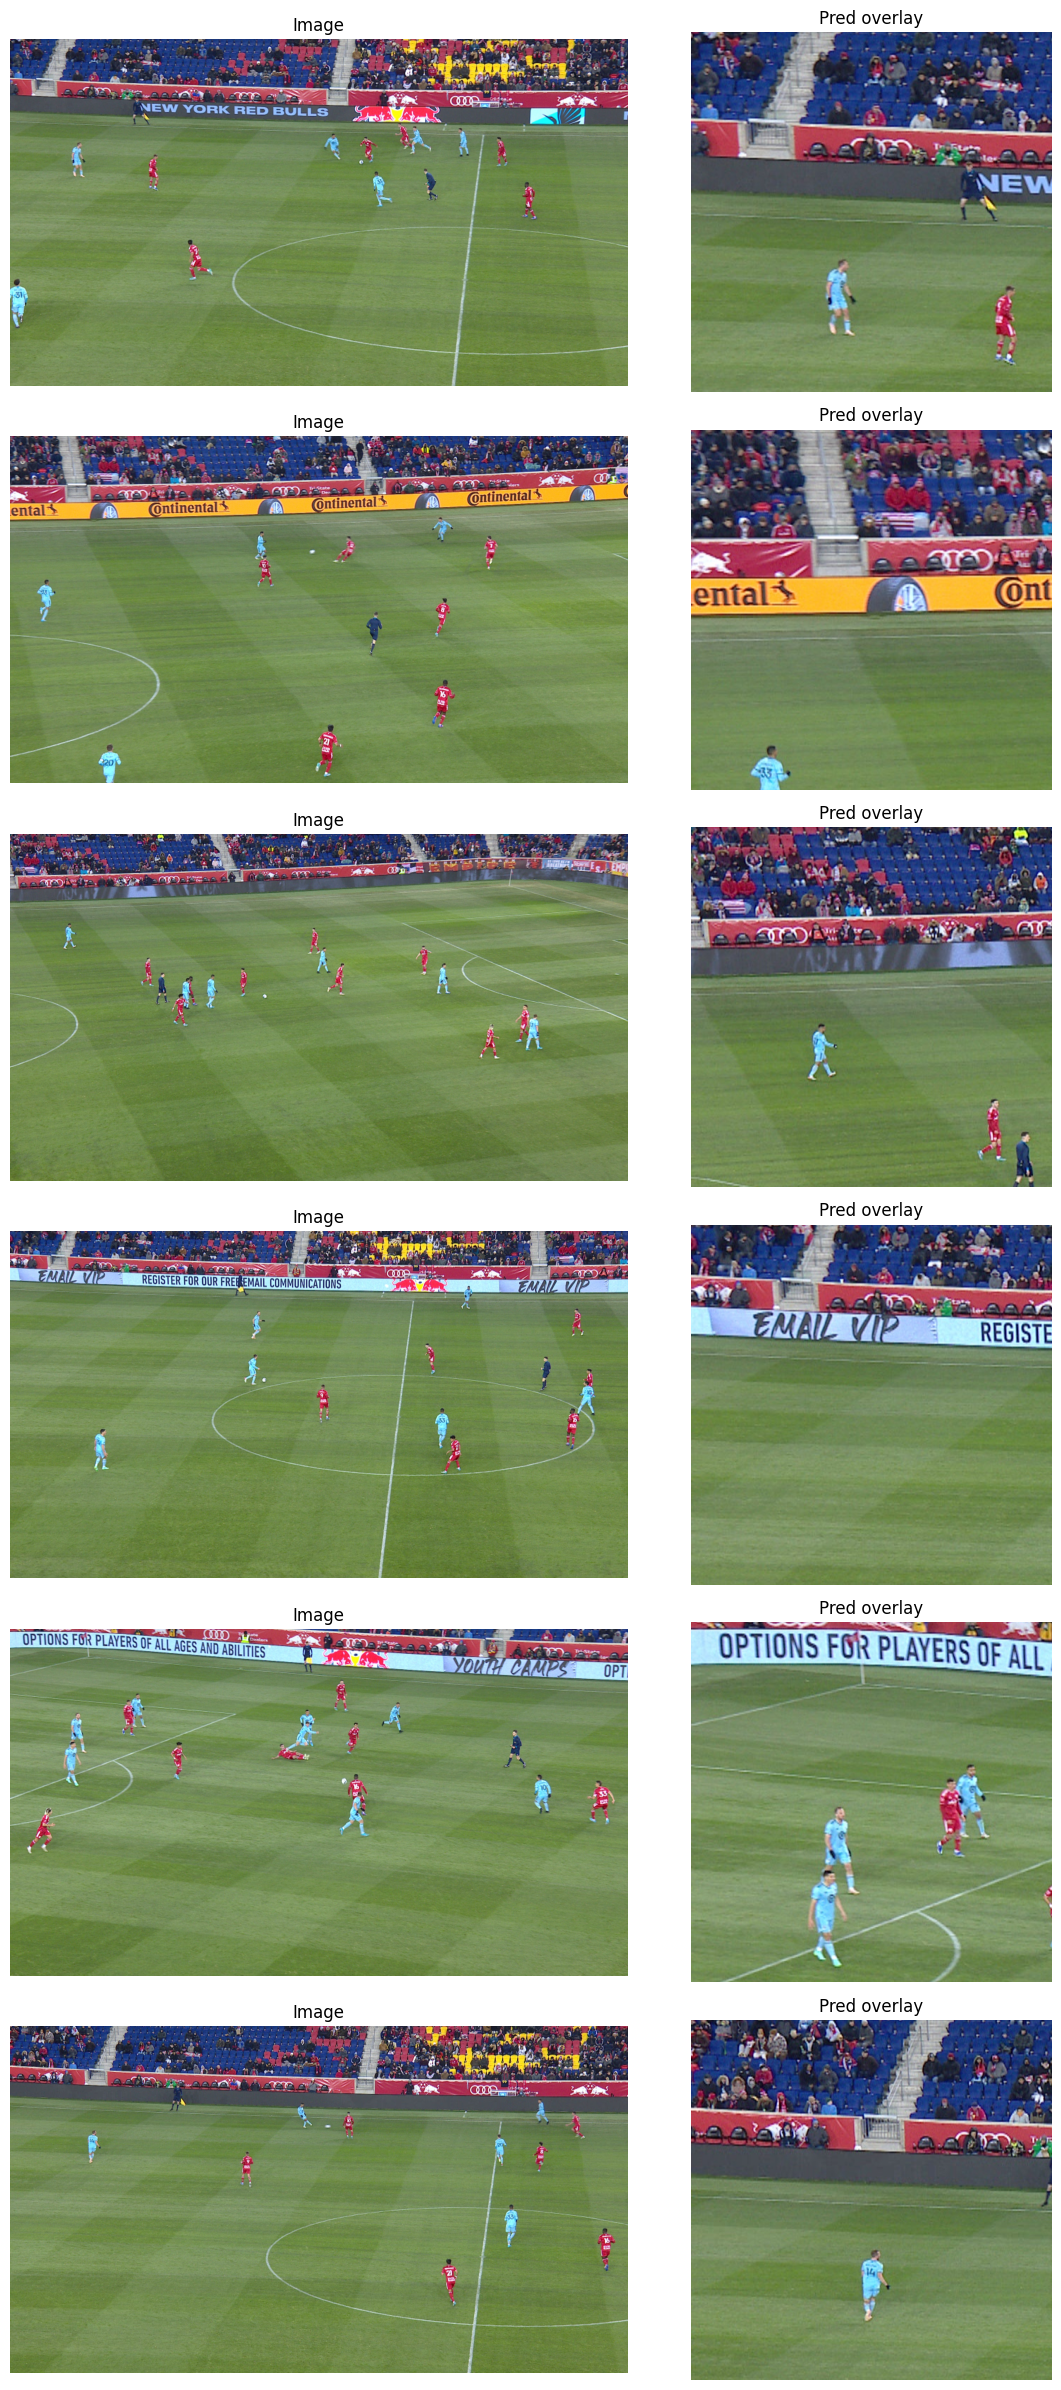

In [13]:
def predict_image(model, image, device, transforms=valid_transforms, thr=0.5):
    model.eval()
    img = np.array(image.convert('RGB'))
    augmented = transforms(image=img)
    tensor = augmented['image'].unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(tensor)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()
    mask = (pred > thr).astype('uint8')
    return mask, pred

def tta_predict(model, image, device, transforms=valid_transforms, thr=0.5):
    model.eval()
    img = np.array(image.convert('RGB'))
    aug1 = transforms(image=img)['image'].unsqueeze(0).to(device)
    img_flipped = np.fliplr(img).copy()
    aug2 = transforms(image=img_flipped)['image'].unsqueeze(0).to(device)
    with torch.no_grad():
        p1 = torch.sigmoid(model(aug1)).cpu().numpy()[0,0]
        p2 = np.fliplr(torch.sigmoid(model(aug2)).cpu().numpy()[0,0])
        p = (p1 + p2) / 2.0
    mask = (p > thr).astype('uint8')
    return mask, p

nshow = min(6, len(valid_pairs))
plt.figure(figsize=(12, 4 * nshow))
for i, (imgp, mskp) in enumerate(valid_pairs[:nshow]):
    img = Image.open(imgp).convert('RGB')
    gt = np.array(Image.open(mskp).convert('L'))
    mask_pred, prob = tta_predict(model, img, CFG['device'], transforms=valid_transforms)
    plt.subplot(nshow, 2, 2*i + 1)
    plt.imshow(img); plt.title('Image'); plt.axis('off')
    plt.subplot(nshow, 2, 2*i + 2)
    plt.imshow(img); plt.imshow(np.ma.masked_where(mask_pred == 0, mask_pred), alpha=0.6); plt.title('Pred overlay'); plt.axis('off')
plt.tight_layout(); plt.show()

# **Visualization & Movement extraction**


Visualizing 3 frame pairs.
Pair 1: indices (3,58), centers t=0, centers t+1=0, movements=0
Pair 2: indices (91,96), centers t=0, centers t+1=0, movements=0
Pair 3: indices (69,18), centers t=0, centers t+1=0, movements=0


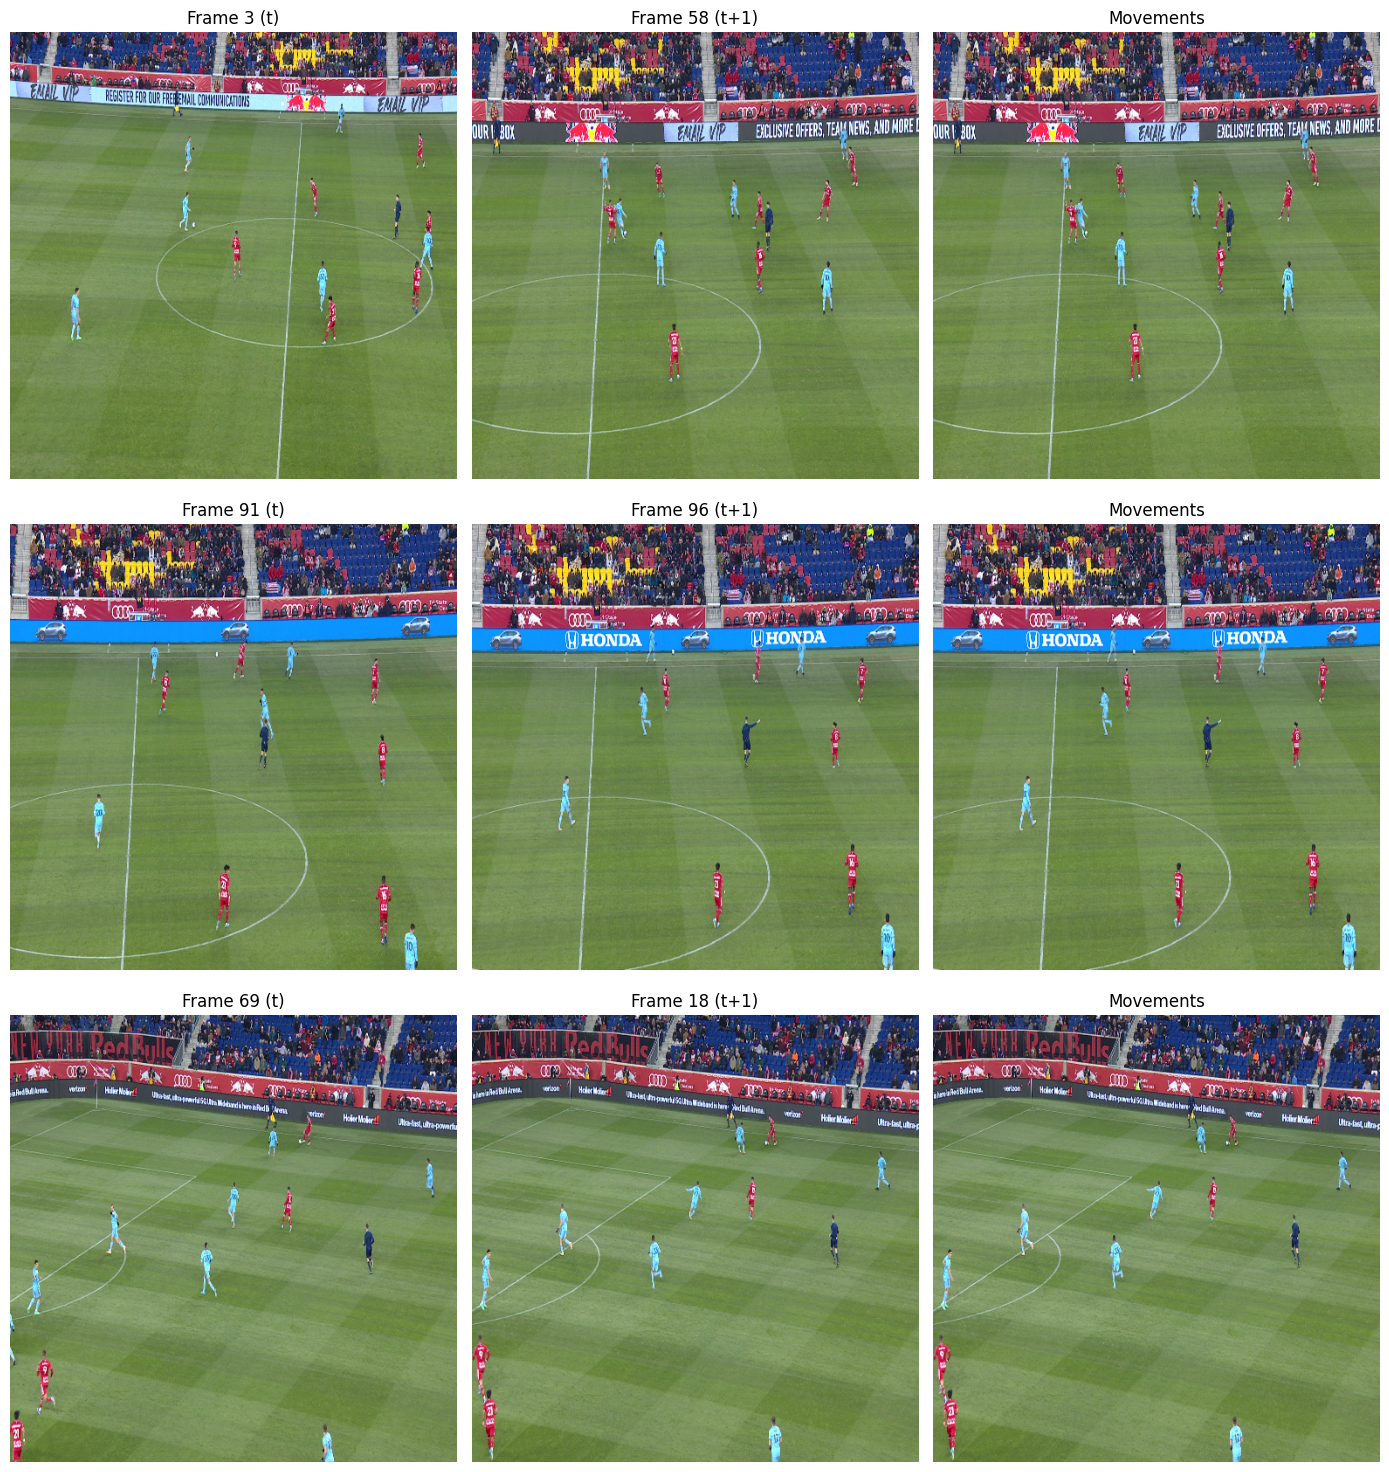

In [14]:
import re, random, math

NUM_PAIRS = 3                
THR = 0.5                   
PIXELS_PER_METER = None      
FRAME_TIME = None            

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def denormalize_tensor(img_tensor):
    """Convert normalized tensor (C,H,W) to uint8 numpy image (H,W,3)."""
    arr = img_tensor.cpu().numpy()
    arr = np.transpose(arr, (1,2,0)).copy()
    mn, mx = arr.min(), arr.max()

    if mn >= 0.0 and mx <= 1.05:
        return (arr * 255.0).astype(np.uint8)

    if mn >= -5.0 and mx <= 5.0:
        img = (arr * IMAGENET_STD[None,None,:] + IMAGENET_MEAN[None,None,:])
        return (np.clip(img, 0.0, 1.0) * 255.0).astype(np.uint8)

    img = (arr - mn) / (mx - mn + 1e-9)
    return (img * 255.0).astype(np.uint8)

def get_centers_from_mask(mask):
    """Extract centers of connected components from binary mask."""
    centers = []
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w*h < 50:  
            continue
        centers.append((int(x + w/2), int(y + h/2), w, h))
    return centers

def pair_indices_by_filename_order(dataset_pairs):
    """Try to build adjacency list based on numeric part of filenames."""
    stems = []
    for (imgp, mskp) in dataset_pairs:
        stems.append(str(imgp.stem if hasattr(imgp, 'stem') else Path(imgp).stem))
    nums = []
    for s in stems:
        m = re.findall(r"\d+", s)
        nums.append(int(m[-1]) if m else None)
    if sum(1 for n in nums if n is not None) < len(nums)//2:
        return None
    idxs = sorted(range(len(nums)), key=lambda i: (nums[i] if nums[i] is not None else 10**9 + i))
    adjacency = [(idxs[k], idxs[k+1]) for k in range(len(idxs)-1)]
    return adjacency

def visualize_movements_pairs(model, dataset, device, num_pairs=3, thr=THR,
                              pixels_per_meter=None, frame_time=None):
    model.eval()

    dataset_pairs = dataset.pairs if hasattr(dataset, "pairs") else None
    adjacency = pair_indices_by_filename_order(dataset_pairs) if dataset_pairs else None

    chosen_pairs = []
    if adjacency:
        random.shuffle(adjacency)
        chosen_pairs = adjacency[:num_pairs]
    else:
        L = len(dataset)
        if L < 2:
            raise RuntimeError("Dataset too small for movement pairs")
        for _ in range(num_pairs):
            i = random.randint(0, L-2)
            chosen_pairs.append((i, i+1))

    print(f"Visualizing {len(chosen_pairs)} frame pairs.")

    fig_h = 5 * len(chosen_pairs)
    plt.figure(figsize=(14, fig_h))

    for idx_pair_i, (i1, i2) in enumerate(chosen_pairs):
        try:
            img1_t, _ = dataset[i1]
            img2_t, _ = dataset[i2]
        except Exception as e:
            print(f"Failed to load dataset[{i1}] or [{i2}]: {e}")
            continue

        with torch.no_grad():
            inp1 = img1_t.unsqueeze(0).to(device)
            inp2 = img2_t.unsqueeze(0).to(device)
            out1 = torch.sigmoid(model(inp1))[0,0].cpu().numpy()
            out2 = torch.sigmoid(model(inp2))[0,0].cpu().numpy()

        mask1 = (out1 > thr).astype(np.uint8)
        mask2 = (out2 > thr).astype(np.uint8)

        centers1 = get_centers_from_mask(mask1)
        centers2 = get_centers_from_mask(mask2)

        img1 = denormalize_tensor(img1_t)
        img2 = denormalize_tensor(img2_t)

        overlay = img2.copy()
        overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)

        movements = []
        for c in centers1:
            x1,y1,w1,h1 = c
            if len(centers2) == 0:
                continue
            nearest = min(centers2, key=lambda c2: math.hypot(c2[0]-x1, c2[1]-y1))
            x2,y2,w2,h2 = nearest
            dist_px = math.hypot(x2-x1, y2-y1)
            dist_m = dist_px / pixels_per_meter if pixels_per_meter else None
            speed_mps = (dist_m / frame_time) if (dist_m is not None and frame_time) else None
            movements.append(((x1,y1),(x2,y2), dist_px, dist_m, speed_mps))

            cv2.circle(overlay_bgr, (int(x1),int(y1)), 8, (0,255,0), 2)
            cv2.arrowedLine(overlay_bgr, (int(x1),int(y1)), (int(x2),int(y2)),
                            (0,0,255), 2, tipLength=0.3)
            txt = f"{dist_px:.1f}px"
            if dist_m is not None:
                txt += f", {dist_m:.2f}m"
            if speed_mps is not None:
                txt += f", {speed_mps:.2f}m/s"
            cv2.putText(overlay_bgr, txt, (int((x1+x2)/2)+5, int((y1+y2)/2)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

        overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

        print(f"Pair {idx_pair_i+1}: indices ({i1},{i2}), centers t={len(centers1)}, "
              f"centers t+1={len(centers2)}, movements={len(movements)}")

        row = idx_pair_i
        plt.subplot(len(chosen_pairs), 3, row*3 + 1)
        plt.imshow(img1); plt.title(f"Frame {i1} (t)"); plt.axis('off')

        plt.subplot(len(chosen_pairs), 3, row*3 + 2)
        plt.imshow(img2); plt.title(f"Frame {i2} (t+1)"); plt.axis('off')

        plt.subplot(len(chosen_pairs), 3, row*3 + 3)
        plt.imshow(overlay_rgb); plt.title("Movements"); plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_movements_pairs(model, valid_ds, device=CFG['device'], num_pairs=NUM_PAIRS,
                          thr=THR, pixels_per_meter=PIXELS_PER_METER, frame_time=FRAME_TIME)